#**TextVectorization() Layer**

#*How It Works*

The TextVectorization() layer in Keras automates / simplifies much of the textual pre-processing we might want to do. By default, it simply changes all text to lowercase, removes punctuation, and splits into 1-grams based on white space. Some integers are reserved in the resulting encoding. Most notably, the value of 1 is reserved for tokens that did not appear in the original corpus that was used to construct the integer encoding ([UNK]).

In [ ]:
import tensorflow as tf
import string
import re
from tensorflow import keras

def custom_standardization_fn(string_tensor):
    lowercase_string = tf.strings.lower(string_tensor) # We convert upper case characters to lowercase.
    return tf.strings.regex_replace(
        lowercase_string, f"[{re.escape(string.punctuation)}]", "") # We find and remove punctuation.
  
def custom_split_fn(string_tensor):
    return tf.strings.split(string_tensor) # By default the separator is white space.
 
text_vectorization = keras.layers.TextVectorization(
    output_mode="int",
    standardize=custom_standardization_fn,
    split=custom_split_fn,
)

dataset = [
    "I write, erase, rewrite",
    "Erase again, and then",
    "A poppy blooms.",
]

text_vectorization.adapt(dataset)
text_vectorization.get_vocabulary()

['',
 '[UNK]',
 'erase',
 'write',
 'then',
 'rewrite',
 'poppy',
 'i',
 'blooms',
 'and',
 'again',
 'a']

Let's try using this layer to encode a sentence.

In [ ]:
vocabulary = text_vectorization.get_vocabulary()

test_sentence = "I like to write practice sentences about a poppy that blooms again and again..." 
encoded_sentence = text_vectorization(test_sentence)
print(encoded_sentence.numpy())

inverse_vocab = dict(enumerate(vocabulary))
decoded_sentence = " ".join(inverse_vocab[int(i)] for i in encoded_sentence)
print(decoded_sentence)

[ 7  1  1  3  1  1  1 11  6  1  8 10  9 10]
i [UNK] [UNK] write [UNK] [UNK] [UNK] a poppy [UNK] blooms again and again


#*Incorporating Into TF Dataset Pipeline*

There is a textfile equivalent function to what we'd seen previously for image data, called text_dataset_from_directory(). The folder structure works the same way as before and individual observations / documents should appear as separate .txt files in the folder. 

Let's try this out using the IMDB Review dataset (an un-processed copy of it)...

In [1]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup
!cat aclImdb/train/pos/4077_10.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  10.9M      0  0:00:07  0:00:07 --:--:-- 17.3M
I first saw this back in the early 90s on UK TV, i did like it then but i missed the chance to tape it, many years passed but the film always stuck with me and i lost hope of seeing it TV again, the main thing that stuck with me was the end, the hole castle part really touched me, its easy to watch, has a great story, great music, the list goes on and on, its OK me saying how good it is but everyone will take there own best bits away with them once they have seen it, yes the animation is top notch and beautiful to watch, it does show its age in a very few parts but that has now become part of it beauty, i am so glad it has came out on DVD as it is one of my top 10 films of all time. Buy it or rent it just see it, best viewing is at night alone with drin

We now have the root folder with test and train directories. Inside each of those directories we have neg and pos subdirectories, which in turn contain lots of .txt files (one per movie review).

In [ ]:
!ls aclImdb/test/neg

labeledBow.feat  neg  pos  urls_neg.txt  urls_pos.txt


Here, we are going to start by creating a validation sample (so we have train, validation and test). To do this, we will siphon off 20% of the files in each category (pos and neg), and put them into a new folder (validation). We will first shuffle the files before selecting which ones to copy.

In [2]:
import os, pathlib, shutil, random
  
base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val" 
train_dir = base_dir / "train" 
for category in ("neg", "pos"):
    os.makedirs(val_dir / category)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

Now we can make our text datasets... 

In [3]:
from tensorflow import keras
batch_size = 32 
  
train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


Let's see what these datasets look like... 

In [4]:
for inputs, targets in train_ds:
    print("inputs.shape:", inputs.shape) # We have 32 reviews per batch.
    print("inputs.dtype:", inputs.dtype) # They are strings.
    print("targets.shape:", targets.shape) # We have 32 labels per batch.
    print("targets.dtype:", targets.dtype) # They are integers.
    print("inputs[0]:", inputs[0]) # Here is the first example
    print("targets[0]:", targets[0])
    break

inputs.shape: (32,)
inputs.dtype: <dtype: 'string'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor(b"Unless I'm sadly mistaken, I rented A Nightmare on Elm Street 3 several years ago and there was a music video, I'm pretty sure which was called Dream Warriors, at the end of it, and I rented this one on DVD hoping that the video would be there because it was one of the funniest things I've ever seen. It's amazing how stuff from the 80s is so funny now, but nothing is funnier than 80s rap videos. There was this rap group singing that song Dream Warriors on the VHS version of this movie after the credits, and they're all wearing like denim jackets with no shirt underneath and form fitting jean shorts that are all frayed at the bottoms like Daisy Dukes. What could make a rap group look more foolish I can't imagine.<br /><br />(spoilers) At any rate, I was disappointed in looking for that video on the DVD version, so all I had was this mediocre installment in the 

Now we can apply our TextVectorization layer to the datasets... 

In [5]:
text_vectorization = keras.layers.TextVectorization(
    max_tokens=20000,
    output_mode="multi_hot", # This is requesting hot encodings.
)

text_only_train_ds = train_ds.map(lambda x, y: x) # This lambda function will just return the text sample for each observation and drop the label.
text_vectorization.adapt(text_only_train_ds) # We can then apply our vectorizer to this corpus of data, and it will create the vocabulary, etc.
 
binary_1gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y), # Then we can apply the resulting vectorizer to the dataset, again via lambda function.
    num_parallel_calls=4)
binary_1gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_1gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

Now each *new* dataset yields vectorized / processed versions of the observation's text, and the associated label.

In [6]:
for x, y in train_ds:
  print(x[0])
  break

for x, y in binary_1gram_train_ds:
  print(x[0].numpy()) 
  break

tf.Tensor(b"When i was told of this movie i thought it would be another chick flick. I was wrong. This movie sends a powerful message about judging others. I was deeply moved. Everyone i have encountered, I have recommended this movie to. No one has come back saying it was bad. Busy, also did a great job with her role in this film. I don't know much about her acting career but wow, they way she pulled off the end of this fill was great.<br /><br />At the beginning it was a little slow. But after she went to the hospital....wow, the movie picks up again. i have no idea why this movie hasn't been spoken of in the movie world. My wish would be for this movie to be released again and advertised more...because it sends a powerful message in a mere hour and a half.", shape=(), dtype=string)
[1. 1. 1. ... 0. 0. 0.]


#*Train a Model*

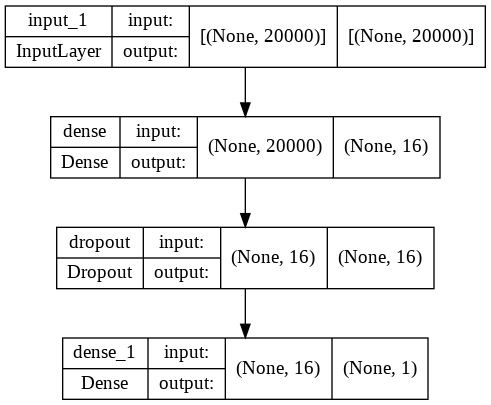

In [7]:
max_tokens=20000
hidden_dim=16

inputs = keras.Input(shape=(max_tokens,))
x = keras.layers.Dense(hidden_dim, activation="relu")(inputs)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

keras.utils.plot_model(model,show_shapes=True)

And, now we can train and then test the model...

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("binary_1gram.keras",
                                    save_best_only=True)
]

history = model.fit(binary_1gram_train_ds.cache(),  # Note: using .cache will make it so file opening and data reading are up front, not during each epoch
          validation_data=binary_1gram_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)

model = keras.models.load_model("binary_1gram.keras") 

print(f"Test acc: {model.evaluate(binary_1gram_test_ds)[1]:.3f}")

Epoch 1/10
625/625 [==============================] - 13s 19ms/step - loss: 0.4019 - accuracy: 0.8291 - val_loss: 0.2859 - val_accuracy: 0.8882
Epoch 2/10
625/625 [==============================] - 5s 7ms/step - loss: 0.2732 - accuracy: 0.9028 - val_loss: 0.2873 - val_accuracy: 0.8888
Epoch 3/10
625/625 [==============================] - 5s 8ms/step - loss: 0.2379 - accuracy: 0.9174 - val_loss: 0.2967 - val_accuracy: 0.8904
Epoch 4/10
625/625 [==============================] - 5s 8ms/step - loss: 0.2284 - accuracy: 0.9249 - val_loss: 0.3159 - val_accuracy: 0.8888
Epoch 5/10
625/625 [==============================] - 5s 8ms/step - loss: 0.2189 - accuracy: 0.9284 - val_loss: 0.3281 - val_accuracy: 0.8906
Epoch 6/10
625/625 [==============================] - 5s 7ms/step - loss: 0.2119 - accuracy: 0.9315 - val_loss: 0.3454 - val_accuracy: 0.8888
Epoch 7/10
625/625 [==============================] - 5s 7ms/step - loss: 0.2104 - accuracy: 0.9334 - val_loss: 0.3541 - val_accuracy: 0.8898
Epoc

#*Bigrams, TF-IDF, etc.*

Let's try this again, but with a bit of sequence information. We'll incorporate bi-grams (note that we had done this before, manually).

In [8]:
text_vectorization_bigram = keras.layers.TextVectorization(
    max_tokens=20000, # adding more tokens to allow for increase due to bigrams.
    output_mode="multi_hot", # This is requesting hot encodings; to get term counts we could request "count" as the output mode, and tf-idf using "tf-idf"
    ngrams=2 # We could also do (1,2) here for both unigrams AND bigrams
)

text_only_train_ds = train_ds.map(lambda x, y: x) # This lambda function will just return the text sample for each observation and drop the label.
text_vectorization_bigram.adapt(text_only_train_ds) # We can then apply our vectorizer to this corpus of data, and it will create the vocabulary, etc.
 
binary_2gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization_bigram(x), y), # Then we can apply the resulting vectorizer to the dataset, again via lambda function.
    num_parallel_calls=4)
binary_2gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization_bigram(x), y),
    num_parallel_calls=4)
binary_2gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization_bigram(x), y),
    num_parallel_calls=4)

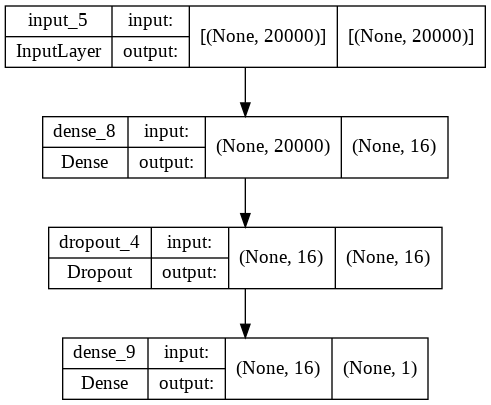

In [ ]:
max_tokens=20000
hidden_dim=16

inputs = keras.Input(shape=(max_tokens,))
x = keras.layers.Dense(hidden_dim, activation="relu")(inputs)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

keras.utils.plot_model(model,show_shapes=True)

We do 1.5-2% better in our test accuracy when we add in the bigrams. But, ultimately, the bigrams are only a crude representation of sequence information. We need to switch to proper sequence models to (potentially) do better.

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("binary_2gram.keras",
                                    save_best_only=True)
]

history = model.fit(binary_2gram_train_ds.cache(),  # Note: using .cache will make it so file opening and data reading are up front, not during each epoch
          validation_data=binary_2gram_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)

model = keras.models.load_model("binary_2gram.keras") 

print(f"Test acc: {model.evaluate(binary_2gram_test_ds)[1]:.3f}")

Epoch 1/10
625/625 [==============================] - 8s 13ms/step - loss: 0.4054 - accuracy: 0.8282 - val_loss: 0.3087 - val_accuracy: 0.8804
Epoch 2/10
625/625 [==============================] - 4s 6ms/step - loss: 0.2712 - accuracy: 0.9087 - val_loss: 0.3129 - val_accuracy: 0.8846
Epoch 3/10
625/625 [==============================] - 4s 6ms/step - loss: 0.2351 - accuracy: 0.9230 - val_loss: 0.3367 - val_accuracy: 0.8852
Epoch 4/10
625/625 [==============================] - 4s 6ms/step - loss: 0.2229 - accuracy: 0.9295 - val_loss: 0.3578 - val_accuracy: 0.8802
Epoch 5/10
625/625 [==============================] - 4s 6ms/step - loss: 0.2157 - accuracy: 0.9330 - val_loss: 0.3771 - val_accuracy: 0.8792
Epoch 6/10
625/625 [==============================] - 4s 6ms/step - loss: 0.2075 - accuracy: 0.9365 - val_loss: 0.3815 - val_accuracy: 0.8748
Epoch 7/10
625/625 [==============================] - 4s 7ms/step - loss: 0.2016 - accuracy: 0.9383 - val_loss: 0.4240 - val_accuracy: 0.8736
Epoch

#*Without TF Dataset Pipelines*

Let's say we just want to work with text data in memory... we can do that too... going back to our simple example... 

In [12]:
import tensorflow as tf 
import numpy as np 

dataset = [
    "I write, erase, rewrite",
    "Erase again, and then",
    "A poppy blooms.",
]

dataset = np.stack(dataset).reshape(3,1)
labels = np.array([1, 0, 1])

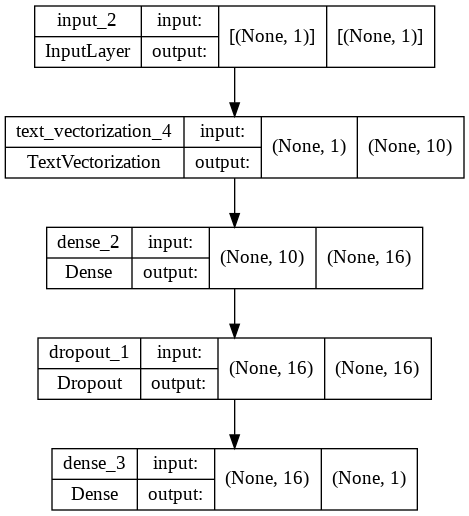

In [13]:
text_vectorization_bigram = keras.layers.TextVectorization(
    max_tokens=10, # adding more tokens to allow for increase due to bigrams.
    output_mode="multi_hot", # This is requesting hot encodings; to get term counts we could request "count" as the output mode, and tf-idf using "tf-idf"
    ngrams=2 # We could also do (1,2) here for both unigrams AND bigrams
)

text_vectorization_bigram.adapt(dataset)

inputs = keras.Input(shape=(1), dtype=tf.string) # Be careful! You need to specify a string datatype here, or the model will produce errors when you go to fit. 
processing = text_vectorization_bigram(inputs)
x = keras.layers.Dense(hidden_dim, activation="relu")(processing)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

keras.utils.plot_model(model,show_shapes=True)

In [ ]:
model.fit(dataset,labels,batch_size=1,epochs=2)

Epoch 1/2
3/3 [==============================] - 1s 4ms/step - loss: 0.7142 - accuracy: 0.3333
Epoch 2/2
3/3 [==============================] - 0s 5ms/step - loss: 0.5424 - accuracy: 0.6667
